# Model 3

## Load the data and process it

`model3.py` is a code to choose the best features and train a model using them.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import LeaveOneOut, train_test_split
import numpy as np

def coefficient_of_variance(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_actual = np.mean(y_true)
    if mean_actual != 0:
        cv = rmse / mean_actual
    else:
        cv = float('inf')
    return cv

# Load and concatenate all files
files = [
    'standardized_high_high_high_high_high_high.csv',
    'standardized_high_high_high_none_none_none.csv',
    'standardized_high_none_none_none_none_none.csv',
    'standardized_low_low_low_low_low_low.csv',
    'standardized_low_low_low_none_none_none.csv',
    'standardized_low_none_none_none_none_none.csv',
    'standardized_none_none_none_none_none_none.csv'
]
df_list = []
for file in files:
    df_temp = pd.read_csv(f'../../matrix/set_plot/{file}')
    df_temp['File'] = file
    df_list.append(df_temp)
df_combined = pd.concat(df_list, ignore_index=True)

# Data preprocessing
df_grouped_combined = df_combined.groupby(['PlotID', 'Generation', 'File']).mean().reset_index()
df_grouped_G2_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G2'].drop(columns=['Generation'])
df_grouped_G3_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G3'].drop(columns=['Generation'])
df_grouped_G4_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G4'].drop(columns=['Generation'])
df_grouped_G2_combined.columns = [str(col) + '_G2' for col in df_grouped_G2_combined.columns]
df_grouped_G3_combined.columns = [str(col) + '_G3' for col in df_grouped_G3_combined.columns]
df_grouped_G2_G3_combined = pd.merge(df_grouped_G2_combined.rename(columns={'PlotID_G2': 'PlotID', 'File_G2': 'File'}),
                                     df_grouped_G3_combined.rename(columns={'PlotID_G3': 'PlotID', 'File_G3': 'File'}),
                                     on=['PlotID', 'File'])

# Calculate the top 5 bacteria in G4
mean_abundance_grouped_G4_combined = df_grouped_G4_combined.iloc[:, 1:].mean()
top_5_bacteria_grouped_G4_combined = mean_abundance_grouped_G4_combined.sort_values(ascending=False).head(5).index.tolist()


C:\Users\DuYih\AppData\Local\Temp\ipykernel_5744\414815766.py:39: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped_combined = df_combined.groupby(['PlotID', 'Generation', 'File']).mean().reset_index()
C:\Users\DuYih\AppData\Local\Temp\ipykernel_5744\414815766.py:50: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_abundance_grouped_G4_combined = df_grouped_G4_combined.iloc[:, 1:].mean()


## Train the model (Use Random Forest)


In [2]:

# Prepare the data for training and testing
X_grouped_G2_G3_combined = pd.get_dummies(df_grouped_G2_G3_combined, columns=['File']).drop(columns=['PlotID'])
y_grouped_G4_combined = df_grouped_G4_combined[df_grouped_G4_combined['PlotID'].isin(df_grouped_G2_G3_combined['PlotID'])][top_5_bacteria_grouped_G4_combined]

# Model training
X_train_grouped_G2_G3_combined, X_test_grouped_G2_G3_combined, y_train_grouped_G4_combined, y_test_grouped_G4_combined = train_test_split(X_grouped_G2_G3_combined, y_grouped_G4_combined, test_size=0.2, random_state=42)
model_grouped_G2_G3_G4_combined = RandomForestRegressor()
model_grouped_G2_G3_G4_combined.fit(X_train_grouped_G2_G3_combined, y_train_grouped_G4_combined)
y_pred_grouped_G2_G3_G4_combined = model_grouped_G2_G3_G4_combined.predict(X_test_grouped_G2_G3_combined)

# Calculate MSE and SE
mse_grouped_G2_G3_G4_combined = mean_squared_error(y_test_grouped_G4_combined, y_pred_grouped_G2_G3_G4_combined)
se_grouped_G2_G3_G4_combined = sqrt(mse_grouped_G2_G3_G4_combined)

# Initialize LeaveOneOut cross-validator
loo = LeaveOneOut()

# Perform Leave-One-Out Cross-Validation for CV
cv_scores = []
for train_index, test_index in loo.split(X_grouped_G2_G3_combined):
    X_train_loo, X_test_loo = X_grouped_G2_G3_combined.iloc[train_index], X_grouped_G2_G3_combined.iloc[test_index]
    y_train_loo, y_test_loo = y_grouped_G4_combined.iloc[train_index], y_grouped_G4_combined.iloc[test_index]
    model_grouped_G2_G3_G4_combined.fit(X_train_loo, y_train_loo)
    y_pred_loo = model_grouped_G2_G3_G4_combined.predict(X_test_loo)
    cv_score = coefficient_of_variance(y_test_loo.to_numpy().flatten(), y_pred_loo.flatten())
    cv_scores.append(cv_score)

# Calculate mean CV score
mean_cv_score = np.mean(cv_scores)


## Data visualization

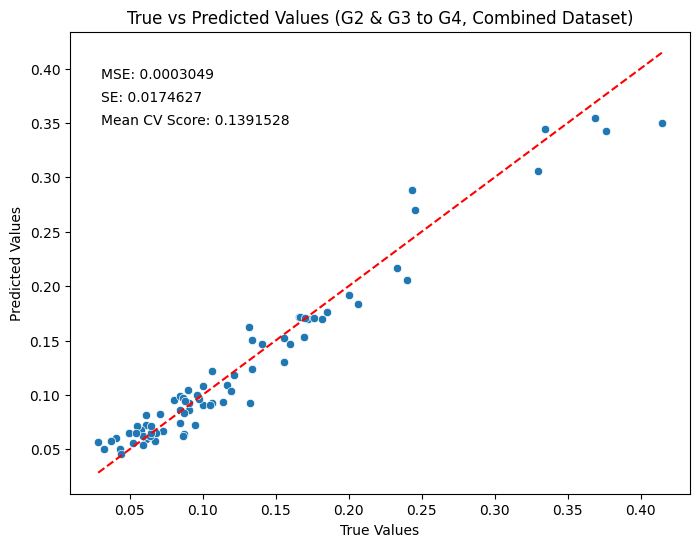

In [3]:

# Data visualization
y_true_grouped_G2_G3_G4_combined_flat = y_test_grouped_G4_combined.to_numpy().flatten()
y_pred_grouped_G2_G3_G4_combined_flat = y_pred_grouped_G2_G3_G4_combined.flatten()
df_plot_grouped_G2_G3_G4_combined = pd.DataFrame({'True Values': y_true_grouped_G2_G3_G4_combined_flat, 'Predicted Values': y_pred_grouped_G2_G3_G4_combined_flat})
plt.figure(figsize=(8, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=df_plot_grouped_G2_G3_G4_combined)
plt.plot([min(y_true_grouped_G2_G3_G4_combined_flat), max(y_true_grouped_G2_G3_G4_combined_flat)], [min(y_true_grouped_G2_G3_G4_combined_flat), max(y_true_grouped_G2_G3_G4_combined_flat)], color='red', linestyle='--')
plt.title('True vs Predicted Values (G2 & G3 to G4, Combined Dataset)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.annotate(f'MSE: {mse_grouped_G2_G3_G4_combined:.7f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.annotate(f'SE: {se_grouped_G2_G3_G4_combined:.7f}', xy=(0.05, 0.85), xycoords='axes fraction')
plt.annotate(f'Mean CV Score: {mean_cv_score:.7f}', xy=(0.05, 0.8), xycoords='axes fraction')
# plt.savefig('../figure/figure5.pdf')
plt.show()
